In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from skimage import io as skio
import datasetdatabase as dsdb
from aicsfeature.extractor import structure
from aicsimage import io, processing
import matplotlib.pyplot as plt

os.environ["DSDB_PROCESS_LIMIT"] = "16"

### Load metadata

In [3]:
with open('../../data-raw/QCB_cell_meta.pkl', 'rb') as fp:
    df_meta = pickle.load(fp)
df_meta.shape

(10116, 11)

In [4]:
df_meta.columns

Index(['cell_id', 'cell_ver', 'czi_filename', 'idx_in_stack', 'mitosis',
       'mode', 'roi', 'src_csv', 'src_csv_row', 'str_ver', 'structure_name'],
      dtype='object')

### Available structures

In [62]:
# OK # TOM20 - Mitochondria - [network]
# OK # GOLGI - ST6GAL - []

# discuss # ACTB - []
# discuss # ACTN1 - []
# discuss # MYOSIN - []

# DSP - [distance]
# LMNB - [texture]
# CENT - [distance]
# FBL - [texture]

# LAMP1 - []
# TUBA - Microtubule - [network]
# SEC61 - ER - [network]
# ZO1 - [network]

df_meta['structure_name'].unique()

array(['FBL', 'ZO1', 'ACTB', 'ACTN1', 'MYOSIN', 'DSP', 'TUBA', 'LMNB',
       'TOM20', 'SEC61', 'GOLGI', 'CENT', 'LAMP1'], dtype=object)

### Subset of meta for which Golgi is available

In [59]:
df_meta_golgi = df_meta.loc[df_meta.structure_name=='MYOSIN']
df_meta_golgi = df_meta_golgi.reset_index(drop=True)
df_meta_golgi.shape

(667, 11)

### Display Golgi structure for a few cells

In [60]:
rootf = '/allen/aics/assay-dev/Analysis/QCB_database/cell_info'

/allen/aics/assay-dev/Analysis/QCB_database/cell_info/fa17558d-166a-4c24-be2e-eb9ee4d3bdc8/seg.ome.tif
seg (3, 73, 309, 240) raw (3, 73, 309, 240)


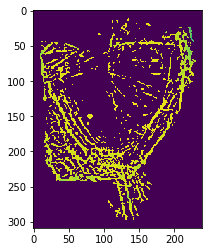

   str_1st_axis_length_mean  str_1st_axis_x_mean  str_1st_axis_y_mean  \
0                 10.277945             0.173524            -0.026147   

   str_1st_axis_z_mean  str_1st_eigenvalue_mean  str_2nd_axis_length_mean  \
0             0.340361                 0.534167                  4.512347   

   str_2nd_axis_x_mean  str_2nd_axis_y_mean  str_2nd_axis_z_mean  \
0             0.136675             0.139699             0.477662   

   str_2nd_eigenvalue_mean            ...             str_highest_z_max  \
0                 3.065538            ...                           1.0   

   str_lowest_z_max  str_meridional_eccentricity_max  str_sphericity_max  \
0               0.0                              0.0            0.346769   

   str_surface_area_max  str_volume_max  str_x_centroid_max  \
0                   1.0             4.0                 0.0   

   str_y_centroid_max  str_z_centroid_max  str_number_of_components  
0                 0.0            0.158442                   

In [61]:
cids = np.random.randint(df_meta_golgi.shape[0], size=1)
for cid in cids:
    seg_path = os.path.join(rootf,df_meta_golgi.cell_id[cid],'seg.ome.tif')
    raw_path = os.path.join(rootf,df_meta_golgi.cell_id[cid],'raw.ome.tif')
    print(seg_path)
    SEG = skio.imread(seg_path)
    RAW = skio.imread(raw_path)
    print('seg',SEG.shape,'raw',RAW.shape)
    plt.imshow(np.max(RAW[2,:,:,:],axis=0)*np.max(SEG[2,:,:,:],axis=0)) # channels: 0-dna, 1-mem
    plt.show()
    
df = structure.GetFeatures(None, seg=SEG[2,:,:,:])
print(df.head())

In [47]:
import ivvv

ModuleNotFoundError: No module named 'ivvv'

# Debugging section

In [21]:
from skimage.measure import label, regionprops
seg = SEG[2,:,:,:]
seg[seg>0] = 1
regions = label(seg)

In [22]:
regions.max()

24

In [13]:
skel = skeletonize_3d(regions.astype(np.uint8))

/home/matheus.viana/anaconda3/envs/qcb/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [30]:
from skimage.morphology import skeletonize_3d
for i in range(1,regions.max()+1):
    comp=np.copy(regions)
    comp[comp!=i] = 0

    skel = skeletonize_3d(comp.astype(np.uint8))

    skel[skel>0] = 1

    skel = np.pad(skel,1,'constant')

    skel_degree = np.copy(skel)

    z_pxl, y_pxl, x_pxl = np.where(skel>0)

    nv = len(z_pxl)

    for  x, y, z in zip(x_pxl,y_pxl,z_pxl):
        neigh = skel[z-1:z+2,y-1:y+2,x-1:x+2]
        skel_degree[z,y,x] = neigh.sum()

    nt = skel.sum()
    n0 = np.sum(skel_degree==(0+1))
    n1 = np.sum(skel_degree==(1+1))
    n2 = np.sum(skel_degree==(2+1))
    n3 = np.sum(skel_degree==(3+1))
    n4 = np.sum(skel_degree>=(4+1))
    
    x = np.nan if nv==0 else nt if n2==nt else 1 if n0==1 else 2.0*nt / (n1+3*n3+4*n4)
    
    print(nv,nt,n0,x)

/home/matheus.viana/anaconda3/envs/qcb/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


12 12 0 12.0
29 29 0 4.833333333333333
23 23 0 7.666666666666667
12 12 0 2.0
3 3 0 3.0
1867 1867 0 3.345878136200717
25 25 0 25.0
3 3 0 3.0
3 3 0 3.0
10 10 0 10.0
13 13 0 13.0
2 2 0 2.0
3 3 0 3.0
0 0 0 nan
12 12 0 2.0
7 7 0 3.5
14 14 0 14.0
0 0 0 nan
23 23 0 11.5
4 4 0 4.0
0 0 0 nan
3 3 0 3.0
3 3 0 3.0
6 6 0 6.0
15 15 0 3.0
191 191 0 5.162162162162162
0 0 0 nan
0 0 0 nan
10 10 0 10.0
3 3 0 3.0
2 2 0 2.0
3 3 0 3.0
3 3 0 3.0
7 7 0 7.0
10 10 0 10.0
1 1 1 1
3 3 0 3.0
5 5 0 5.0
3 3 0 3.0
2 2 0 2.0
3 3 0 3.0
15 15 0 3.0
20 20 0 20.0
2 2 0 2.0


In [23]:
q=np.random.randint(2,size=50**3).reshape(50,50,50)
s=skeletonize_3d(q.astype(np.uint8))
s.max()

/home/matheus.viana/anaconda3/envs/qcb/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


1

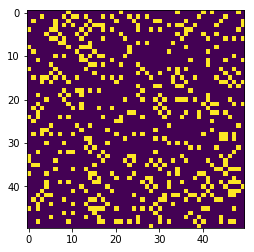

In [28]:
plt.imshow(s[25,:,:]) # channels: 0-dna, 1-mem
plt.show()

In [26]:
np.bincount(q.reshape(-1))

array([62561, 62439])

In [34]:
with open('tmp_str_tubulin_drug_ds.pkl', 'rb') as fp:
    df = pickle.load(fp)
df.head()

,str_1st_axis_length_mean,str_1st_axis_x_mean,str_1st_axis_y_mean,str_1st_axis_z_mean,str_1st_eigenvalue_mean,str_2nd_axis_length_mean,str_2nd_axis_x_mean,str_2nd_axis_y_mean,str_2nd_axis_z_mean,str_2nd_eigenvalue_mean,...,str_highest_z_max,str_lowest_z_max,str_meridional_eccentricity_max,str_sphericity_max,str_surface_area_max,str_volume_max,str_x_centroid_max,str_y_centroid_max,str_z_centroid_max,str_number_of_components
cell_id,,,,,,,,,,,,,,,,,,,,,
0ade9e16-db16-420a-9ccb-8cad3b32ee04,14.798033,0.024586,-0.004287,0.224918,4.803388,7.670079,0.006007,0.073887,0.223402,12.109414,...,1.0,0.0,0.927025,0.128077,1.0,4.0,0.0,0.0,0.250000,169
ca1f5d66-da95-4208-bd89-65c6c614a9f1,12.937500,0.028279,0.002090,0.278976,4.614739,7.296232,0.058276,0.064020,0.148109,17.058853,...,1.0,0.0,0.701910,0.115398,1.0,5.0,0.0,0.0,0.200000,152
662de948-69c0-4b93-92f8-f3bcc7e38655,15.299885,0.009339,0.035619,0.174126,5.858826,7.881318,0.014729,0.029123,0.249833,12.259033,...,1.0,0.0,0.867509,0.113549,1.0,4.0,0.0,0.0,0.229167,151
7806500f-6df9-4b9f-8b23-fde6fd09d40e,15.951804,0.035106,-0.017611,0.087218,7.918414,7.883403,-0.124808,0.076068,0.296748,15.019507,...,1.0,0.0,0.921322,0.144092,1.0,4.0,0.0,0.0,0.250000,75
17fcb999-72a5-425d-b485-b02edb16651c,13.973257,0.010717,0.028601,0.191060,6.023861,7.397392,0.036879,-0.110419,0.215429,11.759683,...,1.0,0.0,0.866025,0.130504,1.0,4.0,0.0,0.0,0.250000,134


In [35]:
df.str_

AttributeError: 'DataFrame' object has no attribute 'str_'

# Debugging uploaded datasets

In [2]:
import datasetdatabase as dsdb
prod = dsdb.DatasetDatabase(config='/allen/aics/assay-dev/Analysis/QCB_database/prod_config.json')

In [3]:
df_mem = prod.get_dataset(name="QCB_DRUG_MEM_feature")

Reconstructing dataset...
[============================================================] 100.0% 1519/1519 ~ 0:0:0 remaining


In [4]:
df_dna = prod.get_dataset(name="QCB_DNA_feature")

Reconstructing dataset...
[============================================================] 100.0% 10116/10116 ~ 0:0:0 remaining


In [5]:
df_st6 = prod.get_dataset(name="QCB_ST6GAL_feature")

Reconstructing dataset...
[============================================================] 100.0% 694/694 ~ 0:0:0 remaining


In [6]:
df_tom = prod.get_dataset(name="QCB_TOM20_feature")

Reconstructing dataset...
[============================================================] 100.0% 900/900 ~ 0:0:0 remaining


In [8]:
df_mem.ds.head()

,cell_id,mem_1st_axis_length,mem_1st_axis_x,mem_1st_axis_y,mem_1st_axis_z,mem_1st_eigenvalue,mem_2nd_axis_length,mem_2nd_axis_x,mem_2nd_axis_y,mem_2nd_axis_z,...,mem_intensity_std,mem_intensity_sum,mem_lowest_z,mem_meridional_eccentricity,mem_sphericity,mem_surface_area,mem_volume,mem_x_centroid,mem_y_centroid,mem_z_centroid
0,c17a53d0-7ff6-4106-ab53-d2be3240f168,267.127038,-0.634430,0.276844,-0.721703,348.527358,186.586495,-0.367236,0.713614,0.596568,...,14.333805,250768724,10,0.992144,0.630151,80242,1069162,0.591821,0.417372,0.448139
1,77f11f0d-66d9-49c5-b2b8-be40777780ed,276.640338,-0.674465,0.443528,-0.590237,314.602494,149.508576,-0.310908,0.554482,0.771936,...,13.053778,254132833,10,0.993980,0.688018,73612,1071757,0.506054,0.496192,0.476548
2,427284a7-02b2-440b-a1b0-28c0b8f12379,202.939604,0.420049,-0.007429,-0.907471,689.239313,235.827940,0.315931,-0.936217,0.153903,...,11.160515,379234734,10,0.942940,0.661495,99353,1584293,0.557881,0.448066,0.561900
3,0241af5b-4133-4525-9d14-9a65f8a93f6f,330.426213,0.944737,-0.122517,0.304076,611.672630,221.386405,0.065806,0.979534,0.190216,...,8.047440,459813101,10,0.989685,0.616602,120124,1895510,0.594131,0.458245,0.664083
4,a705b03f-7af4-4fba-9e8f-8b20b085a1ab,307.129410,-0.642918,-0.639757,0.421149,538.984090,218.814125,0.583535,-0.052962,0.810359,...,8.124758,417616549,10,0.980214,0.616734,112595,1720677,0.553269,0.484786,0.403611


In [9]:
df_dna.ds.head()

,cell_id,dna_1st_axis_length,dna_1st_axis_x,dna_1st_axis_y,dna_1st_axis_z,dna_1st_eigenvalue,dna_2nd_axis_length,dna_2nd_axis_x,dna_2nd_axis_y,dna_2nd_axis_z,...,dna_intensity_std,dna_intensity_sum,dna_lowest_z,dna_meridional_eccentricity,dna_sphericity,dna_surface_area,dna_volume,dna_x_centroid,dna_y_centroid,dna_z_centroid
0,c17a53d0-7ff6-4106-ab53-d2be3240f168,109.337658,0.603440,-0.698648,0.384383,356.531315,90.462273,0.018198,0.493981,0.869282,...,3.485325,97222278,18,0.808917,0.960141,28756,431389,0.513864,0.506527,0.494152
1,77f11f0d-66d9-49c5-b2b8-be40777780ed,106.810961,0.608830,-0.425128,0.669770,270.888203,103.903495,-0.462736,0.495457,0.735118,...,3.173162,96970829,23,0.894999,0.955483,28734,427762,0.518674,0.477328,0.497231
2,427284a7-02b2-440b-a1b0-28c0b8f12379,134.997277,-0.584743,0.309793,0.749735,423.124361,117.196834,0.516881,-0.570030,0.638671,...,3.962362,158686153,26,0.889850,0.949459,40425,707071,0.516016,0.501644,0.503281
3,0241af5b-4133-4525-9d14-9a65f8a93f6f,137.421519,0.986138,0.026559,0.163787,397.895199,119.479554,-0.158325,0.445966,0.880936,...,3.552392,166023910,51,0.914144,0.915326,43037,735192,0.527129,0.502983,0.461167
4,a705b03f-7af4-4fba-9e8f-8b20b085a1ab,125.821203,0.907576,0.132322,0.398492,414.042773,104.429758,-0.051403,-0.906894,0.418212,...,4.518123,130537426,15,0.859747,0.954873,36664,615959,0.479548,0.490886,0.501606


In [10]:
df_st6.ds.head()

,cell_id,str_1st_axis_length_max,str_1st_axis_length_mean,str_1st_axis_length_min,str_1st_axis_length_std,str_1st_axis_x_max,str_1st_axis_x_mean,str_1st_axis_x_min,str_1st_axis_x_std,str_1st_axis_y_max,...,str_x_centroid_min,str_x_centroid_std,str_y_centroid_max,str_y_centroid_mean,str_y_centroid_min,str_y_centroid_std,str_z_centroid_max,str_z_centroid_mean,str_z_centroid_min,str_z_centroid_std
0,90ab6fcc-399c-42df-8ba9-5c44f1c7521c,2.000000,13.086780,56.176311,14.683055,-0.855206,0.017996,0.941039,0.482913,-0.752131,...,0.594723,0.126554,0.000000,0.390502,0.597356,0.154471,0.304545,0.456852,0.585337,0.106929
1,adea03e4-f36c-4a42-85db-a4ecc8f89382,5.177586,19.573029,47.706612,13.642593,-0.249230,0.472854,0.977627,0.440534,-0.937481,...,0.602566,0.113019,0.250000,0.441921,0.558729,0.093686,0.333333,0.460227,0.567213,0.081542
2,62120bed-5495-4ae0-bbb5-d66a309594f8,2.000000,16.856042,41.223098,14.866750,-0.986439,0.270290,0.887773,0.568891,-0.948683,...,0.484230,0.103458,0.250000,0.405939,0.580420,0.113626,0.250000,0.467649,0.621053,0.141414
3,92385354-8f42-4458-a9b2-e8a40f271f5c,9.085817,22.750133,37.096888,10.096829,-0.606159,0.071281,0.950026,0.565110,-0.999997,...,0.516001,0.074863,0.417338,0.476414,0.545992,0.039089,0.109317,0.475745,0.602727,0.138934
4,76577653-cb97-4573-96fc-f5d386843ac4,2.213594,18.977290,35.846415,11.280885,-0.888749,0.149116,0.999377,0.553377,-0.994717,...,0.539018,0.064247,0.266667,0.435929,0.529577,0.074639,0.250000,0.489973,0.621687,0.103643


In [11]:
df_tom.ds.head()

,cell_id,str_1st_axis_length_max,str_1st_axis_length_mean,str_1st_axis_length_min,str_1st_axis_length_std,str_1st_axis_x_max,str_1st_axis_x_mean,str_1st_axis_x_min,str_1st_axis_x_std,str_1st_axis_y_max,...,str_x_centroid_min,str_x_centroid_std,str_y_centroid_max,str_y_centroid_mean,str_y_centroid_min,str_y_centroid_std,str_z_centroid_max,str_z_centroid_mean,str_z_centroid_min,str_z_centroid_std
0,611b2011-36af-490f-8379-0eebbc10ed1c,1.414214,18.417565,156.279999,28.903632,-0.933983,0.028942,0.948683,0.514016,-0.978127,...,0.616823,0.126491,0.0,0.385054,0.600679,0.148454,0.250000,0.428338,0.606061,0.103937
1,5ae609cb-638a-4b57-a58f-6ab4e818d6d9,2.000000,23.628892,144.512414,27.144333,-0.922019,0.097902,1.000000,0.578084,-0.834232,...,0.601945,0.107946,0.0,0.414949,0.531755,0.096167,0.236364,0.434234,0.587850,0.092279
2,af9f137c-02ed-4d06-9211-e1ae4e689e36,1.000000,25.389580,137.568856,28.740455,-0.852642,0.181029,0.948683,0.528734,-0.973249,...,0.614153,0.096969,0.0,0.403835,0.642342,0.122787,0.250000,0.437554,0.593974,0.096163
3,bee793c4-30df-442c-921f-136badee4856,4.114359,23.958104,113.263084,22.490657,-0.808662,-0.090663,0.707107,0.406011,-0.707107,...,0.569406,0.112073,0.0,0.395832,0.536705,0.144494,0.333333,0.494976,0.696983,0.078357
4,1e901aba-5490-446a-b50b-64da7314a768,1.000000,24.014028,157.022973,42.110300,-0.905887,-0.087390,0.996593,0.535142,-0.758770,...,0.575108,0.141303,0.0,0.332615,0.607564,0.176634,0.250000,0.446545,0.684208,0.105435


In [8]:
with open('../../data-raw/QCB_DRUG_MEM_feature.pkl', 'rb') as fp:
    df_mem = pickle.load(fp)

In [9]:
df_mem.head()

,str_1st_axis_length_mean,str_1st_axis_x_mean,str_1st_axis_y_mean,str_1st_axis_z_mean,str_1st_eigenvalue_mean,str_2nd_axis_length_mean,str_2nd_axis_x_mean,str_2nd_axis_y_mean,str_2nd_axis_z_mean,str_2nd_eigenvalue_mean,...,str_highest_z_max,str_lowest_z_max,str_meridional_eccentricity_max,str_sphericity_max,str_surface_area_max,str_volume_max,str_x_centroid_max,str_y_centroid_max,str_z_centroid_max,str_number_of_components
cell_id,,,,,,,,,,,,,,,,,,,,,
0ade9e16-db16-420a-9ccb-8cad3b32ee04,14.798033,0.024586,-0.004287,0.224918,4.803388,7.670079,0.006007,0.073887,0.223402,12.109414,...,1.0,0.0,0.927025,0.128077,1.0,4.0,0.0,0.0,0.250000,169
ca1f5d66-da95-4208-bd89-65c6c614a9f1,12.937500,0.028279,0.002090,0.278976,4.614739,7.296232,0.058276,0.064020,0.148109,17.058853,...,1.0,0.0,0.701910,0.115398,1.0,5.0,0.0,0.0,0.200000,152
662de948-69c0-4b93-92f8-f3bcc7e38655,15.299885,0.009339,0.035619,0.174126,5.858826,7.881318,0.014729,0.029123,0.249833,12.259033,...,1.0,0.0,0.867509,0.113549,1.0,4.0,0.0,0.0,0.229167,151
7806500f-6df9-4b9f-8b23-fde6fd09d40e,15.951804,0.035106,-0.017611,0.087218,7.918414,7.883403,-0.124808,0.076068,0.296748,15.019507,...,1.0,0.0,0.921322,0.144092,1.0,4.0,0.0,0.0,0.250000,75
17fcb999-72a5-425d-b485-b02edb16651c,13.973257,0.010717,0.028601,0.191060,6.023861,7.397392,0.036879,-0.110419,0.215429,11.759683,...,1.0,0.0,0.866025,0.130504,1.0,4.0,0.0,0.0,0.250000,134


In [10]:
with open('../../data-raw/QCB_DRUG_DNA_feature.pkl', 'rb') as fp:
    df_dna = pickle.load(fp)
df_dna.head()

,str_1st_axis_length_mean,str_1st_axis_x_mean,str_1st_axis_y_mean,str_1st_axis_z_mean,str_1st_eigenvalue_mean,str_2nd_axis_length_mean,str_2nd_axis_x_mean,str_2nd_axis_y_mean,str_2nd_axis_z_mean,str_2nd_eigenvalue_mean,...,str_highest_z_max,str_lowest_z_max,str_meridional_eccentricity_max,str_sphericity_max,str_surface_area_max,str_volume_max,str_x_centroid_max,str_y_centroid_max,str_z_centroid_max,str_number_of_components
cell_id,,,,,,,,,,,,,,,,,,,,,
0ade9e16-db16-420a-9ccb-8cad3b32ee04,14.798033,0.024586,-0.004287,0.224918,4.803388,7.670079,0.006007,0.073887,0.223402,12.109414,...,1.0,0.0,0.927025,0.128077,1.0,4.0,0.0,0.0,0.250000,169
ca1f5d66-da95-4208-bd89-65c6c614a9f1,12.937500,0.028279,0.002090,0.278976,4.614739,7.296232,0.058276,0.064020,0.148109,17.058853,...,1.0,0.0,0.701910,0.115398,1.0,5.0,0.0,0.0,0.200000,152
662de948-69c0-4b93-92f8-f3bcc7e38655,15.299885,0.009339,0.035619,0.174126,5.858826,7.881318,0.014729,0.029123,0.249833,12.259033,...,1.0,0.0,0.867509,0.113549,1.0,4.0,0.0,0.0,0.229167,151
7806500f-6df9-4b9f-8b23-fde6fd09d40e,15.951804,0.035106,-0.017611,0.087218,7.918414,7.883403,-0.124808,0.076068,0.296748,15.019507,...,1.0,0.0,0.921322,0.144092,1.0,4.0,0.0,0.0,0.250000,75
17fcb999-72a5-425d-b485-b02edb16651c,13.973257,0.010717,0.028601,0.191060,6.023861,7.397392,0.036879,-0.110419,0.215429,11.759683,...,1.0,0.0,0.866025,0.130504,1.0,4.0,0.0,0.0,0.250000,134
